In [93]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import pickle 
import numpy as np

def interpolate_to_5_minutes(data):
    original_times = data['minutely_15']['time']
    original_precipitation = data['minutely_15']['precipitation']

    num_intervals = len(original_times) * 3
    new_times = []
    new_precipitation = []

    for i in range(len(original_times)):
        time = datetime.fromisoformat(original_times[i])
        for j in range(3):
            new_time = time + timedelta(minutes=5 * j)
            new_times.append(new_time.isoformat())
            new_precipitation.append(original_precipitation[i] / 3)

    rainfall_2_hours = []
    for i in range(len(new_times)):
        start_index = max(i - 24, 0)
        total_rainfall = sum(new_precipitation[start_index:i+1])
        rainfall_2_hours.append(total_rainfall)

    return new_times, new_precipitation, rainfall_2_hours

def iterative_forecasting_with_initialization_and_scaling(model, scaler, X, num_forecasts, num_lags=6):
    # Initialize the lagged features in the first row with zeros
    for lag in range(1, num_lags + 1):
        X[f'percentage_previous_{lag}'] = 0

    # Store the initial features to update them iteratively
    current_features = X.iloc[0].copy()

    # First prediction without scaling
    model_input = current_features.values.reshape(1, -1)
    next_prediction = model.predict(model_input)[0]

    # Update the lagged features for the first prediction
    for lag in range(num_lags - 1, 0, -1):
        current_features[f'percentage_previous_{lag + 1}'] = current_features[f'percentage_previous_{lag}']
    current_features['percentage_previous_1'] = next_prediction

    # Add the updated features and prediction to the DataFrame
    X.loc[len(X)] = current_features

    # Perform subsequent predictions with scaling
    for i in range(1, num_forecasts):
        # Update the lagged features with the new prediction
        for lag in range(num_lags - 1, 0, -1):
            current_features[f'percentage_previous_{lag + 1}'] = current_features[f'percentage_previous_{lag}']
        current_features['percentage_previous_1'] = next_prediction

        # Scale all features for the next prediction
        scaled_features = scaler.transform(current_features.values.reshape(1, -1))

        # Predict the next target with scaled features
        next_prediction = model.predict(scaled_features)[0]

        # Update the current features with the latest prediction
        current_features = X.iloc[i-1].copy()
        current_features.iloc[-num_lags:] = scaled_features[0, -num_lags:]

        # Add the updated features and prediction to the DataFrame
        X.loc[len(X)] = current_features

    return X


In [94]:
# Fetch data from the API
url = 'https://api.open-meteo.com/v1/forecast?latitude=51.55202&longitude=4.586668&minutely_15=precipitation&forecast_days=1'
response = requests.get(url)
data = response.json() if response.status_code == 200 else {}



# Prepare the DataFrame from API data
if data:
    new_times, new_precipitation, rainfall_2_hours = interpolate_to_5_minutes(data)

    api_df = pd.DataFrame({
        'timestamp': pd.to_datetime(new_times),
    })

    api_df['day'] = api_df['timestamp'].dt.day
    api_df['month'] = api_df['timestamp'].dt.month
    api_df['dayofweek'] = api_df['timestamp'].dt.dayofweek
    api_df['hour'] = api_df['timestamp'].dt.hour
    
    api_df['rainfall_current'] = new_precipitation
    api_df['rainfall_previous_2_hours'] = rainfall_2_hours

    api_df.to_csv('api_data.csv', index=False)
else:
    print("Failed to retrieve or process API data")

# Load model from pickle file
with open('model_randomforest_14.pkl', 'rb') as file:
    model = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
    
# Prepare initial features for forecasting
# Assuming the model requires specific features, start with zeros for lagged ones
X_initial = api_df.drop(columns=['timestamp'])  # Modify as needed based on your model's requirements
num_forecasts = 6

X_initial

# Perform iterative forecasting with initialized and scaled features
api_df_with_predictions = iterative_forecasting_with_initialization_and_scaling(model, scaler ,X_initial, num_forecasts)

# Show the last few rows with the predictions
api_df_with_predictions.tail(num_forecasts)

c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,day,month,dayofweek,hour,rainfall_current,rainfall_previous_2_hours,percentage_previous_1,percentage_previous_2,percentage_previous_3,percentage_previous_4,percentage_previous_5,percentage_previous_6
288,19.0,12.0,1.0,0.0,0.0,0.0,8.800500,0.000000,0.000000,0.000000,0.000000,0.000000
289,19.0,12.0,1.0,0.0,0.0,0.0,0.007985,0.007986,-0.434696,-0.434696,-0.434696,-0.434695
290,19.0,12.0,1.0,0.0,0.0,0.0,0.542756,-0.434295,-0.434294,-0.456562,-0.456562,-0.456561
291,19.0,12.0,1.0,0.0,0.0,0.0,2.765179,-0.407395,-0.456542,-0.456542,-0.457662,-0.457661
292,19.0,12.0,1.0,0.0,0.0,0.0,3.338025,-0.295603,-0.455189,-0.457661,-0.457660,-0.457717
293,19.0,12.0,1.0,0.0,0.0,0.0,4.167834,-0.266787,-0.449566,-0.457593,-0.457717,-0.457716


In [88]:
results = model.predict(api_df_with_predictions)

c:\Users\Optic\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [89]:
results 

array([ 8.8005    ,  8.8005    ,  8.8005    ,  8.8005    ,  8.88885714,
        8.88885714,  8.88885714,  8.88885714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        9.0155    ,  9.0155    ,  9.0155    ,  9.04692857,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  9.04692857, 11.82357143, 11.08264286, 11.08264286,
       11.08264286, 11.08264286,  9.0155    ,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91935714,
        8.91935714,  8.91935714,  8.91935714,  8.91935714,  8.91

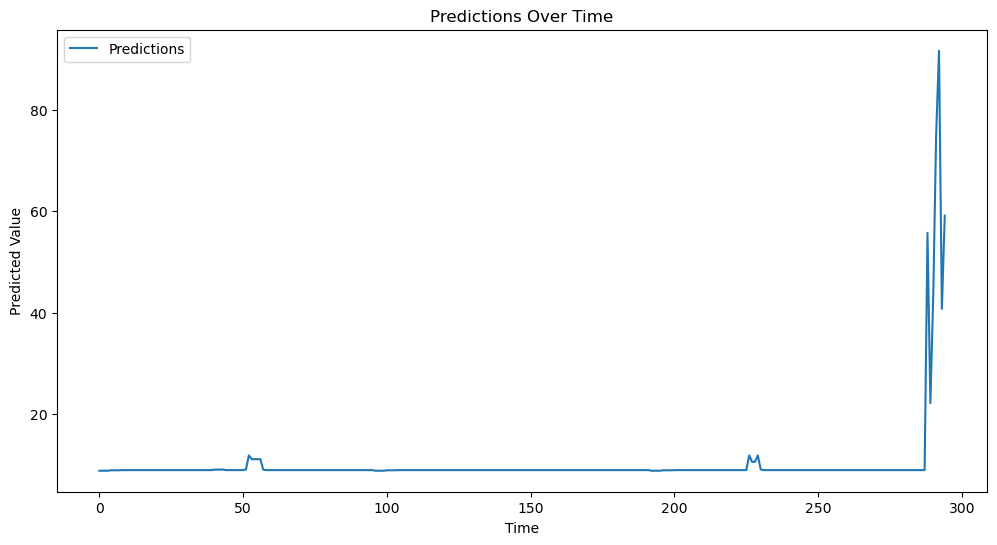

In [90]:
import matplotlib.pyplot as plt

# 1. Line Plot of Predictions Over Time
plt.figure(figsize=(12, 6))
plt.plot(results, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Predictions Over Time')
plt.legend()
plt.show()

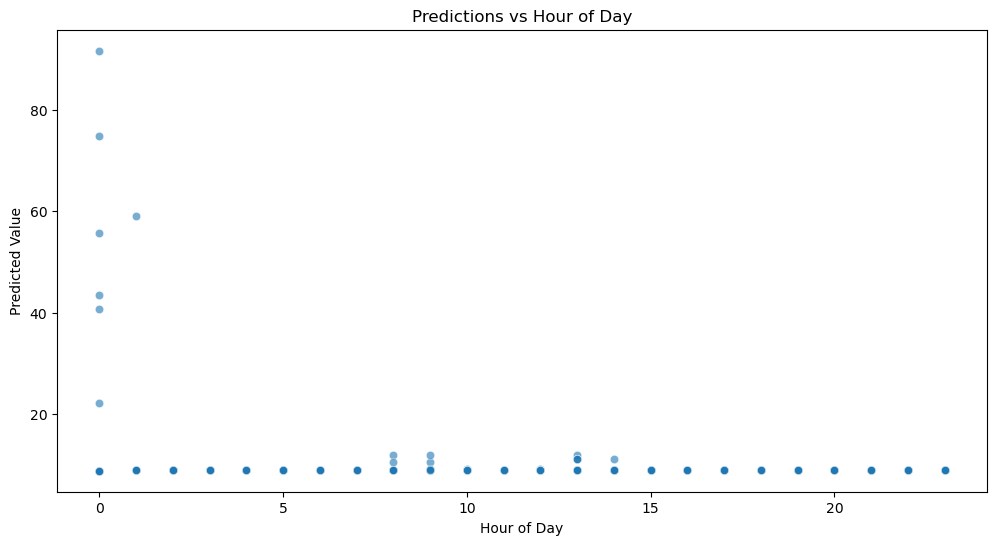

In [91]:
import seaborn as sns

# For scatter plot and boxplot, let's assume we are using 'hour' as the key feature.
# 3. Scatter Plot of Predictions vs Hour
plt.figure(figsize=(12, 6))
sns.scatterplot(data=api_df_with_predictions, x='hour', y=results, alpha=0.6)
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Value')
plt.title('Predictions vs Hour of Day')
plt.show()

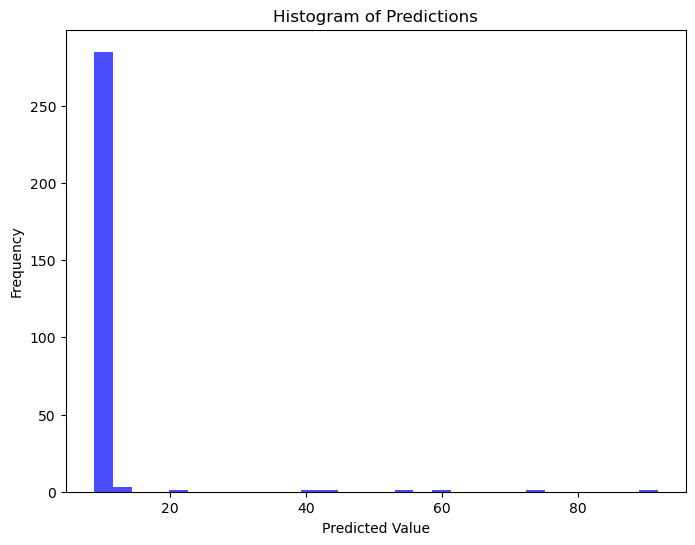

In [92]:
# 2. Histogram of Predictions
plt.figure(figsize=(8, 6))
plt.hist(results, bins=30, color='blue', alpha=0.7)
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.show()

In [1]:
def plot_predictions_and_rainfall(pred_df, pre_pred_df, model_name):
    # plot the predictions in a line chart, put the percentage and rainfull_current against each other
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Rainfall (mm)')
    ax1.plot(pred_df['timestamp'], pred_df['rainfall_current'], color='blue')
    ax1.plot(pre_pred_df['timestamp'], pre_pred_df['rainfall_current'], color='blue', linestyle='dashed')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Percentage (%)')
    ax2.plot(pred_df['timestamp'], pred_df['percentage_current'], color='red')
    ax2.plot(pre_pred_df['timestamp'], pre_pred_df['percentage_current'], color='red', linestyle='dashed')
    ax2.tick_params(axis='y')

    fig.legend(['Rainfall', 'Rainfall pre', 'Percentage', 'Percentage pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Rainfall and percentage full over time - {model_name}')
    plt.show()

In [ ]:
plot_predictions_and_rainfall(api_df_with_predictions, api_df, 'Random Forest')